In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import numpy as np
import time
from numpy import arange, sin, pi, random

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Anomaly"]

In [2]:
from zoo.pipeline.api.keras.layers import Dense, Dropout, Activation, Input
from zoo.pipeline.api.keras.models import Sequential, Model
from bigdl.optim.optimizer import *

/private/var/folders/th/mq68kp9533z31prp3x7fm7rw0000gn/T/spark-b21b6e7d-0122-4ca9-9c90-d587cf7f0a16/userFiles-a3c64b0f-44d5-4efd-926b-25147a9fcb5e/analytics-zoo-0.1.0-SNAPSHOT-python-api.zip/zoo/common/nncontext.py:79: UserWarning: The compile time spark version may not compatible with the Spark runtime version. Compile time version is 2.0.0, runtime version is 2.2.0


## Read data from csv

In [3]:
df = pd.read_csv("data/CPU_example_new_1.csv")

In [4]:
df.shape

(576016, 3)

In [5]:
df.head()

,Time,CPU,Class
0,1,0.090638,0
1,2,0.561039,0
2,3,0.469942,0
3,4,0.542974,0
4,5,0.347671,0


## Basic sanity check of data and normalization

In [6]:
# check for null data
df.isnull().values.any()

# Standard scaling : mean 0, stddev 1
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df['CPU'] = preprocessing.StandardScaler().fit_transform(df['CPU'].values.reshape(-1, 1))
df.head()

,Time,CPU,Class
0,1,-1.763465,0
1,2,0.565446,0
2,3,0.114431,0
3,4,0.476008,0
4,5,-0.490919,0


<bound method Series.count of 0    442816
1    133200
Name: Class, dtype: int64>


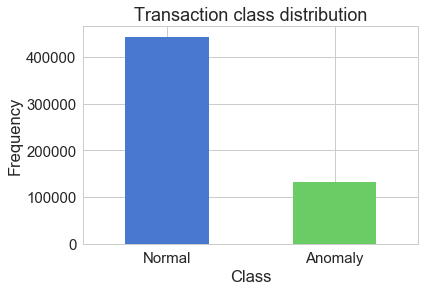

In [7]:
# let's explore the distribution of input data
count_classes = pd.value_counts(df['Class'], sort = False)
print(count_classes.count)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [8]:
# Just checking the relative counts
anomaly = df[df.Class == 1]
normal = df[df.Class == 0]

anomaly.shape

(133200, 3)

In [9]:
normal.shape

(442816, 3)

In [10]:
anomaly.CPU.describe()

count    133200.000000
mean          0.773437
std           0.518100
min          -1.340885
25%           0.430858
50%           0.768378
75%           1.109292
max           4.160799
Name: CPU, dtype: float64

In [11]:
normal.CPU.describe()

count    442816.000000
mean         -0.232651
std           0.992972
min          -4.421980
25%          -0.900659
50%          -0.237575
75%           0.446000
max           3.882385
Name: CPU, dtype: float64

## Any correlation between time and CPU metrics ?

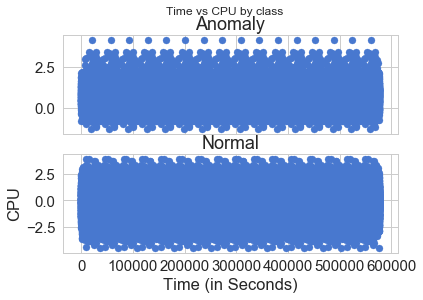

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time vs CPU by class')

ax1.scatter(anomaly.Time, anomaly.CPU)
ax1.set_title('Anomaly')

ax2.scatter(normal.Time, normal.CPU)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('CPU')
plt.show()

## Feature Re-engineering

In [13]:
indexed_df = df.set_index(["Time"])
df = indexed_df.rolling(10).mean()  ## mean over rolling window of size 10

df.loc[df['Class'] > 0.5, 'Class'] = 1.0
df.loc[df['Class'] <= 0.5, 'Class'] = 0.0

df = df[np.isfinite(df['CPU'])]  ## remove NaNs

In [14]:
df.head()

,CPU,Class
Time,,
10,-0.345190,0.0
11,-0.090123,0.0
12,-0.233778,0.0
13,-0.274496,0.0
14,-0.321339,0.0


## Split into training and test data

In [15]:
X_train, X_test = train_test_split(df.values[:, 1:2], test_size=0.2, random_state=RANDOM_SEED)
Y_train, Y_test = train_test_split(df.values[:, -1], test_size=0.2, random_state=RANDOM_SEED)

In [16]:
X_train.shape

(460805, 1)

In [17]:
X_test.shape

(115202, 1)

In [18]:
Y_train.shape

(460805,)

In [19]:
Y_test.shape
class_0 = list(filter(lambda x: x == 0.0, Y_test)) 
class_1 = list(filter(lambda x: x == 1.0, Y_test)) 
print(len(class_0), len(class_1))

95430 19772


# Build the Model

In [20]:
inputs = Input(shape = (X_train.shape[1],))
activation = Activation('relu')(inputs)

hidden1 = Dense(16, activation = 'relu')(activation)
hd1 = Dropout(0.2)(hidden1)

hidden2 = Dense(32, activation = 'relu')(hidden1)
hd2 = Dropout(0.2)(hidden2)

hidden3 = Dense(8, activation = 'relu')(hidden2)
hd3 = Dropout(0.6)(hidden3)

outputs = Dense(output_dim = 1, activation = 'sigmoid')(hd3)

model = Model(inputs, outputs)

creating: createZooKerasInput
creating: createZooKerasActivation
creating: createZooKerasDense
creating: createZooKerasDropout
creating: createZooKerasDense
creating: createZooKerasDropout
creating: createZooKerasDense
creating: createZooKerasDropout
creating: createZooKerasDense
creating: createZooKerasModel


In [21]:
# Build the model
# model = Sequential()

# 1st Fully connected layer + DropOut
# model.add(Dense(16, input_shape=(X_train.shape[1],), activation = 'relu'))
# model.add(Dropout(0.2))

# 2nd Fully connected layer + DropOut
# model.add(Dense(32, activation = 'relu'))
# model.add(Dropout(0.2))

# 3rd Fully connected layer + DropOut
# model.add(Dense(32, activation = 'relu'))
# model.add(Dropout(0.6))

# Output a Sigmoid since we need probability (normal / anomaly)
# model.add(Dense(output_dim=1, activation = 'sigmoid'))
# model.summary()

# Train

In [22]:
log_dir = 'dglogdir'
app_name = 'anomaly-cpu'
tf_model_dump_file_name = 'anomaly-tfdump'

model.save_graph_topology(log_dir + '/' + tf_model_dump_file_name)

model.compile(optimizer=Adam(learningrate = 1e-4),
              loss  = 'binary_crossentropy',
              metrics = ['accuracy'])

model.set_tensorboard(log_dir, app_name)
history = model.fit(X_train, Y_train,
                    nb_epoch = 8,
                    batch_size = 256)

train_summary = TrainSummary(log_dir = log_dir, app_name = app_name)

creating: createAdam
creating: createBCECriterion
creating: createTop1Accuracy
creating: createTrainSummary


In [23]:
# loss = np.array(train_summary.read_scalar('Loss'))
# df_loss = pd.DataFrame({'Loss' :np.array(loss)})
# df_loss.describe

In [24]:
# plt.plot(loss)
# plt.plot(history.history['val_loss'])
# plt.title('model train vs validation loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper right')
# plt.show()

# Now predict on test set

In [25]:
predictions = model.predict(X_test)

In [26]:
first10 = predictions.take(10)
list(map(lambda x: x[0], first10))

[0.0044742147,
 0.0044742147,
 0.0044742147,
 0.0044742147,
 0.0044742147,
 0.0044742147,
 0.0044742147,
 0.9998342,
 0.0044742147,
 0.0044742147]

In [27]:
p = predictions.collect()

## find classes from probabilities
classes = list(map(lambda x: 1.0 if x[0] > 0.5 else 0.0, p))

## check diff between predicted classes and real classes
df_prediction = pd.DataFrame({'Real Class' :np.array(Y_test)})
df_prediction['Prediction'] = classes
df_prediction[ df_prediction['Real Class'] != df_prediction['Prediction'] ]

,Real Class,Prediction


In [28]:
scores = model.evaluate(X_test, Y_test)
list(map(lambda x: (x.result, x.total_num, x.method), scores))

[(1.0, 115202, 'Top1Accuracy')]

# Load another test dataset drawn from same distribution

In [29]:
df = pd.read_csv("data/CPU_example_test.csv")

In [30]:
df.head()

,Time,CPU,Class
0,0,0.465224,0
1,1,0.018208,0
2,2,0.471135,0
3,3,0.392881,0
4,4,0.237540,0


In [31]:
df.isnull().values.any()
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df['CPU'] = preprocessing.StandardScaler().fit_transform(df['CPU'].values.reshape(-1, 1))
df.head()

,Time,CPU,Class
0,0,0.310786,0
1,1,-1.908303,0
2,2,0.340129,0
3,3,-0.048341,0
4,4,-0.819487,0


In [32]:
indexed_df = df.set_index(["Time"])
df = indexed_df.rolling(10).mean()
df.loc[df['Class'] > 0.5, 'Class'] = 1.0
df.loc[df['Class'] <= 0.5, 'Class'] = 0.0
df = df[np.isfinite(df['CPU'])]  ## remove NaNs
df.head()

,CPU,Class
Time,,
9,-0.110524,0.0
10,-0.153550,0.0
11,-0.103063,0.0
12,-0.009661,0.0
13,-0.029654,0.0


In [33]:
X_test = df.values[:, 1:2]
Y_test = df.values[:, -1]

In [34]:
scores = model.evaluate(X_test, Y_test)
results = list(map(lambda x: (x.result, x.total_num, x.method), scores))
print(results)

[(1.0, 3591, 'Top1Accuracy')]


# Another test set

In [35]:
df = pd.read_csv("data/CPU_example_test_1.csv")

In [36]:
df.isnull().values.any()
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df['CPU'] = preprocessing.StandardScaler().fit_transform(df['CPU'].values.reshape(-1, 1))
df.head()

,Time,CPU,Class
0,0,0.360386,1
1,1,-0.578935,0
2,2,0.036519,1
3,3,0.003221,0
4,4,0.439359,1


In [37]:
indexed_df = df.set_index(["Time"])
df = indexed_df.rolling(10).mean()
df.loc[df['Class'] > 0.5, 'Class'] = 1.0
df.loc[df['Class'] <= 0.5, 'Class'] = 0.0
df = df[np.isfinite(df['CPU'])]  ## remove NaNs
df.head()

,CPU,Class
Time,,
9,0.026021,0.0
10,0.016639,0.0
11,-0.062795,0.0
12,0.027721,0.0
13,0.066543,0.0


In [38]:
X_test = df.values[:, 1:2]
Y_test = df.values[:, -1]

In [39]:
scores = model.evaluate(X_test, Y_test)
results = list(map(lambda x: (x.result, x.total_num, x.method), scores))
print(results)

[(1.0, 3591, 'Top1Accuracy')]
